In [1]:
import findspark
findspark.init(r'D:\spark-3.0.0-preview2-bin-hadoop2.7')

In [2]:
from pyspark import SparkContext,SparkConf
from pyspark.streaming import StreamingContext
from textblob import TextBlob
from pyspark.sql import SQLContext,SparkSession
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import string
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import Counter,namedtuple
import socket
import re
from unidecode import unidecode
import time
import nltk
import pandas as p
import json
import hashlib
from elasticsearch import Elasticsearch
from itertools import groupby
from Configuration import cList

## The code to download latest list of stopword and wordnet

In [3]:
#nltk.download('stopwords')
#nltk.download('wordnet')

# creating the stop word list to remove from text

In [4]:
extra_punctuations = ['','.', '``', '...', '\'s', '--', '-', 'n\'t', '_', '–','&']
stopword_list = stopwords.words('english') + list(string.punctuation)+ extra_punctuations + ['rt', 'via','not','and','let','so']
word_count = Counter()

# Intializing required text pre processing objects

In [5]:
analyzer = SentimentIntensityAnalyzer()
wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
tokenizer=TweetTokenizer()

In [6]:
working_directory=r"D:\spark-3.0.0-preview2-bin-hadoop2.7\jars"

In [7]:
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [8]:
def normalize_contractions(tokens):
        """Example of normalization for English contractions.
        Return: generator
        """
        
        for tok in tokens:
            if tok in token_map.keys():
                for item in token_map[tok].split():
                    yield item
            else:
                yield tok

In [9]:
def removeSpecialChars(tweet):
    '''
    Removes special characters which are specifically found in tweets.
    '''
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(tweet, "html.parser")
    tweet = soup.get_text()

    #Convert www.* or https?://* to empty strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)

    #Convert @username to empty strings
    tweet = re.sub('@[^\s]+','',tweet)

    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    
    tweet = re.sub('\.(?!$)', '', tweet)

    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    return tweet 

In [10]:
def remove_emoji(string):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string) 

In [11]:
def remove_nonenglish_charac(string):
    return re.sub('\W+','', string )

# Function to clean the tweet text

In [12]:
def clean_tweet(tweet):
    tweet = unidecode(tweet)
    tweet = str(tweet).lower()
    tweet = expandContractions(tweet)
    tokens = tokenizer.tokenize(tweet)   
    text = ' '.join([tok for tok in tokens if len(tok) > 2 if tok not in stopword_list and not tok.isdigit()])
    text_sam = removeSpecialChars(text)
    text_emoji = remove_emoji(text_sam)
    stem_words= [stemmer.stem(w) for w in text_emoji.split()]
    return ' '.join([wordnet_lemmatizer.lemmatize(word) for word in stem_words])

- Function to decide polarity using vaderSentiment library

In [13]:
def analyze_sentiment_polarity(tweet):
    token = clean_tweet(tweet)
    token_list = str(token).split()
    print(token_list)
    polarity = analyzer.polarity_scores(token)
    if polarity['compound'] > 0.0:
        return 1
    elif polarity['compound'] < 0.0:
        return -1
    else:
        return 0

- Function to convert the rdd text stream to json format 
- Data in json format required to push data to elastic search


In [14]:
def transform(doc):
    _json = json.dumps(doc)
    keys = doc.keys()
    for key in keys:
        if doc[key] == 'null' or doc[key] == 'None':
            del doc[key]
    if 'id' not in keys:
        id = hashlib.sha224(_json.encode('utf-8')).hexdigest()
        doc['id'] = id
    else:
        id = doc['id']
    _json = json.dumps(doc)
    return (id, _json)

 - Function to write the rdd to elastic search and visualize using kibana

In [15]:
def write_rdd_Elastic_Search(rdd):
    try:
        if not rdd.isEmpty(): 
            rdd_mapped = rdd.map(lambda y: y._asdict())
            final_rdd = rdd_mapped.map(transform)
            final_rdd.saveAsNewAPIHadoopFile(
             path='-', 
             outputFormatClass="org.elasticsearch.hadoop.mr.EsOutputFormat",
             keyClass="org.apache.hadoop.io.NullWritable",  
             valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
             conf={ "es.resource" : "tsd/mem", "es.mapping.id":"id", 
                     "es.input.json": "true", "es.net.http.auth.user":"elastic",
                     "es.write.operation":"index", "es.nodes.wan.only":"false",
                     "es.port":"9200" }
                   )
    except Exception as e:
        print("caught exception",e)

- Function to draw the cloud of word
- The word with higher requency will be displayed in larege font and lower frequency in small font
- Used to visualize the important word

In [16]:
def draws_Word_Cloud():
    wordCloud=WordCloud(width=1000,height=700,stopwords = STOPWORDS).generate_from_frequencies(word_count)
    plt.figure(figsize = (15,8))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()
    plt.savefig('{}.png'.format('TweetWordCloud'))
    plt.close()


In [17]:
def genrate_count(rdd):
    if not rdd.isEmpty():
        word_list = rdd.collect()
        word_list=dict([(key.lower(), sum(j for i, j in group)) for key, group in groupby(word_list, key=lambda x: x[0])])
        word_count.update(Counter(word_list))        

# Setting the Spark context and session
- SparkContext(“local[1]”) would not work with Streaming bc 2 threads are required

In [18]:
sc = SparkContext("local[2]", "Twitter Demo").getOrCreate()

In [19]:
spark = SparkSession(sc).builder.appName(sc.appName)\
       .config('spark.driver.extraClassPath', working_directory).getOrCreate()     

In [20]:
ssc = StreamingContext(sc, 2) # 2 is the batch interval in seconds

sqlContext = SQLContext(sc)

When DStream in Spark receives data, it creates an RDD every batch interval.

In [21]:
lines= ssc.socketTextStream(socket.gethostbyname(socket.gethostname()),5557)

In [22]:
sentiment = lines.map(lambda text: (text, analyze_sentiment_polarity(text)))

- code to count the word frequency by cleaning the text

In [23]:
counts = lines.map(lambda text:expandContractions(text)).flatMap(lambda line: line.split(" "))\
             .filter(lambda x: x.lower() not in stopword_list) \
             .map(lambda y: removeSpecialChars(y)).map(lambda w2:remove_nonenglish_charac(w2))\
             .map(lambda w3: remove_emoji(w3)).map(lambda w4: wordnet_lemmatizer.lemmatize(w4))\
             .map(lambda w5:stemmer.stem(w5)).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

In [24]:
fields = ("words", "count")
Wordcount = namedtuple('Wordcount', fields)
sentimentfields = ("text", "Sentiment")
Sentimentobject = namedtuple('Sentimentobject', sentimentfields)

In [25]:
sentiment.map(lambda p: Sentimentobject(p[0], p[1])).foreachRDD(
    lambda rdd: write_rdd_Elastic_Search(rdd))

In [26]:
counts.map(lambda p: Wordcount(p[0], p[1])).foreachRDD(
    lambda rdd: genrate_count(rdd))

In [27]:
if __name__=="__main__":
    try:
        ssc.start()

        ssc.awaitTermination(200)
        
    except Exception as e:
        print("caught exception",e)
    finally:
        ssc.stop()
        print("Spark ession terminated")

Spark ession terminated


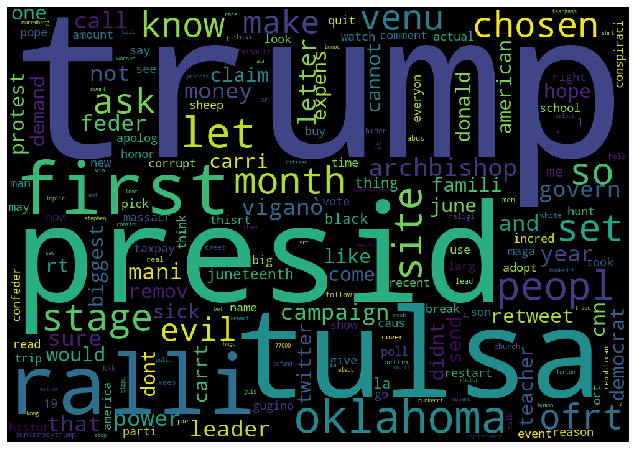

In [28]:
draws_Word_Cloud()